# Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
pd.set_option('display.max_rows', None)  # Display all rows without truncation

In [3]:
data = pd.read_csv("./creditcard2.csv")

In [4]:
data = data.drop(columns=["first", "last", "merchant", "street", "trans_num", "unix_time", "dob"])

###### trans_date_trans_time (object): 거래가 발생한 날짜 및 시간
###### category (object): 거래가 발생한 상품 또는 서비스의 범주
###### amt (float64): 해당 거래의 거래 금액
###### gender (object): 카드 소유자의 성별
###### cc_num (int64): 사용된 신용카드 번호를 나타내는 숫자
###### city (object): 카드 소유자의 거주지 도시
###### state (object): 카드 소유자의 거주지 주(State)
###### zip (int64): 카드 소유자의 거주지 우편번호
###### lat (float64): 카드 소유자의 거주지 위도(latitude)
###### long (float64): 카드 소유자의 거주지 경도(longitude)
###### city_pop (int64): 카드 소유자가 거주하는 도시의 인구 수
###### job (object): 카드 소유자의 직업
###### merch_lat (float64): 가맹점의 위도(latitude) 거래가 발생한 상점의 위치 정보
###### merch_long (float64): 가맹점의 경도(longitude)
###### is_fraud (int64): 거래가 사기(fraud)여부를 나타내는 열입니다. 1은 사기, 0은 정상 거래
###### 
###### <!-- first (object): 카드 소유자의 이름
###### last (object): 카드 소유자의 성
###### merchant (object): 상점명 또는 거래가 발생한 가맹점의 이름
###### street (object): 카드 소유자의 거주지 주소의 거리
###### trans_num (object): 각 거래에 할당된 고유 거래 번호
###### unix_time (int64): 거래가 발생한 시간을 유닉스 타임스탬프 형식으로 나타낸 값
###### dob (object): 카드 소유자의 출생일(Date of Birth) -->

In [5]:
# 고유값 개수와 비율을 확인하는 함수
def unique_value_summary(column_name):
    unique_count = data[column_name].nunique()  # 고유값 개수
    total_count = len(data[column_name])  # 전체 데이터 개수
    unique_ratio = unique_count / total_count  # 고유값 비율
    return unique_count, unique_ratio

# city, state, zip에 대한 고유값 개수 및 비율 확인
columns = data.columns
for col in columns:
    unique_count, unique_ratio = unique_value_summary(col)
    print(f"'{col}' 변수의 고유값 개수: {unique_count}, 고유값 비율: {unique_ratio:.2%}")

'trans_date_trans_time' 변수의 고유값 개수: 1819551, 고유값 비율: 98.23%
'cc_num' 변수의 고유값 개수: 999, 고유값 비율: 0.05%
'category' 변수의 고유값 개수: 14, 고유값 비율: 0.00%
'amt' 변수의 고유값 개수: 60616, 고유값 비율: 3.27%
'gender' 변수의 고유값 개수: 2, 고유값 비율: 0.00%
'city' 변수의 고유값 개수: 906, 고유값 비율: 0.05%
'state' 변수의 고유값 개수: 51, 고유값 비율: 0.00%
'zip' 변수의 고유값 개수: 985, 고유값 비율: 0.05%
'lat' 변수의 고유값 개수: 983, 고유값 비율: 0.05%
'long' 변수의 고유값 개수: 983, 고유값 비율: 0.05%
'city_pop' 변수의 고유값 개수: 891, 고유값 비율: 0.05%
'job' 변수의 고유값 개수: 497, 고유값 비율: 0.03%
'merch_lat' 변수의 고유값 개수: 1754157, 고유값 비율: 94.70%
'merch_long' 변수의 고유값 개수: 1809753, 고유값 비율: 97.70%
'is_fraud' 변수의 고유값 개수: 2, 고유값 비율: 0.00%


# Preprocessing

In [6]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold

In [7]:
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0


### 시간 차이, 거리 차이

###### trans_date_trans_time (object): 거래가 발생한 날짜 및 시간
###### cc_num (int64): 사용된 신용카드 번호를 나타내는 숫자
###### lat (float64): 카드 소유자의 거주지 위도(latitude)
###### long (float64): 카드 소유자의 거주지 경도(longitude)
###### merch_lat (float64): 가맹점의 위도(latitude) 거래가 발생한 상점의 위치 정보
###### merch_long (float64): 가맹점의 경도(longitude)

In [8]:
# 카드 번호와 거래 시간을 기준으로 데이터를 정렬
data = data.sort_values(by=['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

# trans_date_trans_time이 datetime 형식으로 변환되어 있는지 확인 및 변환
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')

# cc_num별로 그룹화하여 이전 거래와의 시간 차이 계산 (초 단위)
data['time_diff'] = data.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()

# 가맹점의 위도와 경도를 사용해 이전 거래와의 거리 차이 계산 (위도와 경도 차이 사용)
data['prev_merch_lat'] = data.groupby('cc_num')['merch_lat'].shift(1)
data['prev_merch_long'] = data.groupby('cc_num')['merch_long'].shift(1)

# 위도와 경도 차이 계산 (벡터화된 연산)
data['merch_distance_diff'] = abs(data['merch_lat'] - data['prev_merch_lat']) + abs(data['merch_long'] - data['prev_merch_long'])

# merch_distance_diff를 time_diff로 나눈 값으로 새로운 열 생성 (속도: 상대적 거리 차이/초)
data['speed'] = data['merch_distance_diff'] / data['time_diff']
data.loc[data['time_diff'] == 0, 'speed'] = np.nan  # 0으로 나누는 경우 처리

# 카드 소유자 거주지와 가맹점의 위치 간의 거리 계산 (위도, 경도 차이)
data['home_to_merch_distance'] = abs(data['lat'] - data['merch_lat']) + abs(data['long'] - data['merch_long'])

# 사용하지 않는 열 삭제
data = data.drop(columns=['prev_merch_lat', 'prev_merch_long', "trans_date_trans_time", "time_diff", "merch_distance_diff", "lat", "long", "merch_lat", "merch_long"])
data.head()

,cc_num,category,amt,gender,city,state,zip,city_pop,job,is_fraud,speed,home_to_merch_distance
0,60416207185,misc_net,7.27,F,Fort Washakie,WY,82514,1645,Information systems manager,0,NaN,1.815415
1,60416207185,gas_transport,52.94,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000037,1.133806
2,60416207185,gas_transport,82.08,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.006641,0.304629
3,60416207185,kids_pets,34.79,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000083,0.925290
4,60416207185,home,27.18,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000897,1.122202


### category

In [9]:
print(data["category"].value_counts().sort_index())

category
entertainment     134118
food_dining       130729
gas_transport     188029
grocery_net        64878
grocery_pos       176191
health_fitness    122553
home              175460
kids_pets         161727
misc_net           90654
misc_pos          114229
personal_care     130085
shopping_net      139322
shopping_pos      166463
travel             57956
Name: count, dtype: int64


In [10]:
# Feature와 Target 설정
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

# 카테고리 그룹핑
category_mapping = {
    'food_dining': 'basic_living',
    'grocery_net': 'basic_living',
    'grocery_pos': 'basic_living',
    'personal_care': 'basic_living',
    'health_fitness': 'basic_living',
    'home': 'home_family',
    'kids_pets': 'home_family',
    'entertainment': 'entertainment_leisure',
    'shopping_net': 'entertainment_leisure',
    'shopping_pos': 'entertainment_leisure',
    'misc_net': 'entertainment_leisure',
    'misc_pos': 'entertainment_leisure',
    'gas_transport': 'transportation_travel',
    'travel': 'transportation_travel'
}

# 카테고리 그룹핑 적용
data['category_grouped'] = data['category'].map(category_mapping)

In [11]:
# 1. cc_num별로 카테고리 사용 비율 계산 및 거래 횟수 계산
category_usage = data.groupby(['cc_num', 'category_grouped']).size().unstack(fill_value=0)
category_usage['transaction_count'] = category_usage.sum(axis=1)  # 각 카드 번호별 거래 회수 계산

# 각 카테고리의 사용 비율 계산 (카드 번호별)
category_usage_ratio = category_usage.div(category_usage['transaction_count'], axis=0)

In [12]:
# 2. 사용자별 usage ratio 차이값 계산 (가중평균 반영)
def calculate_weighted_ratio_diff(ratio_series, transaction_series):
    length = len(ratio_series)
    diffs = []
    weights = []

    # 두 카테고리 간의 usage ratio 차이를 가중평균 계산
    for i in range(length - 1):
        for j in range(i + 1, length):
            diff = abs(ratio_series[i] - ratio_series[j])
            weight = transaction_series[i] + transaction_series[j]  # 두 품목의 거래 횟수를 합산하여 가중치로 사용
            diffs.append(diff)
            weights.append(weight)

    # 가중평균 diff 계산 (weights 합이 0이면 diff는 0으로 처리)
    if sum(weights) > 0:
        weighted_diff = np.average(diffs, weights=weights)
    else:
        weighted_diff = 0

    return weighted_diff

# 각 사용자별 Usage Ratio Diff 계산 (가중평균)
category_usage_ratio['usage_ratio_diff'] = category_usage_ratio.apply(
    lambda row: calculate_weighted_ratio_diff(row[:-1].values, category_usage.loc[row.name].values[:-1]), axis=1
)

In [13]:
# 3. 전체 사용자의 usage_ratio_diff에 대해 가중평균 표준편차 및 median 계산
total_weights = category_usage['transaction_count']
weighted_std = np.sqrt(np.average((category_usage_ratio['usage_ratio_diff'] - category_usage_ratio['usage_ratio_diff'].mean())**2, weights=total_weights))
weighted_median = np.median(category_usage_ratio['usage_ratio_diff'].values)

# 4. 이상치 하한 설정
lower_bound = weighted_median - weighted_std

# 이상치 여부 플래그 추가
category_usage_ratio['unusual_category'] = category_usage_ratio['usage_ratio_diff'].apply(lambda x: 1 if x < lower_bound else 0)

# 5. 'usage_ratio_diff'와 'unusual_category' 정보를 원본 데이터에 병합
data = data.merge(category_usage_ratio[['usage_ratio_diff', 'unusual_category']], left_on='cc_num', right_index=True, how='left')

        category_grouped  unusual_category  unusual_ratio
0           basic_living              4640       0.007431
1  entertainment_leisure              4805       0.007452
2            home_family              2984       0.008850
3  transportation_travel              2945       0.011972


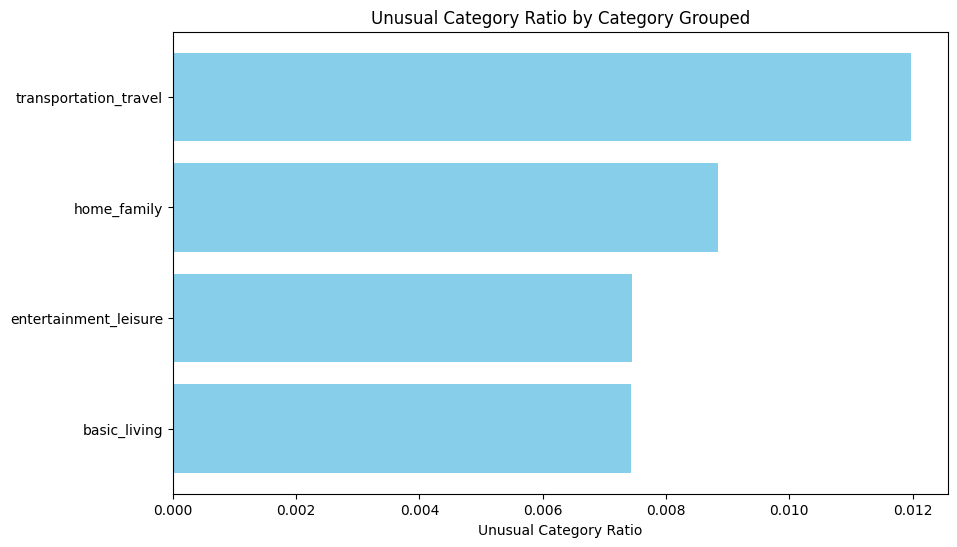

In [14]:
# 각 category_grouped 별로 unusual_category의 합계 계산
unusual_summary = data.groupby('category_grouped')['unusual_category'].sum().reset_index()

# 전체 거래 수 대비 unusual_category 비율 계산
unusual_summary['unusual_ratio'] = unusual_summary['unusual_category'] / data.groupby('category_grouped').size().values

# 결과 확인
print(unusual_summary)

# 시각적으로 확인하기 위해 바 차트로도 표시
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(unusual_summary['category_grouped'], unusual_summary['unusual_ratio'], color='skyblue')
plt.xlabel('Unusual Category Ratio')
plt.title('Unusual Category Ratio by Category Grouped')
plt.show()

In [15]:
data = data.drop(columns=["cc_num", "category", "usage_ratio_diff"])
data = pd.get_dummies(data, columns=['category_grouped'], prefix='category')
data.head()

,amt,gender,city,state,zip,city_pop,job,is_fraud,speed,home_to_merch_distance,unusual_category,category_basic_living,category_entertainment_leisure,category_home_family,category_transportation_travel
0,7.27,F,Fort Washakie,WY,82514,1645,Information systems manager,0,NaN,1.815415,0,False,True,False,False
1,52.94,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000037,1.133806,0,False,False,False,True
2,82.08,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.006641,0.304629,0,False,False,False,True
3,34.79,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000083,0.925290,0,False,False,True,False
4,27.18,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000897,1.122202,0,False,False,True,False


### amt

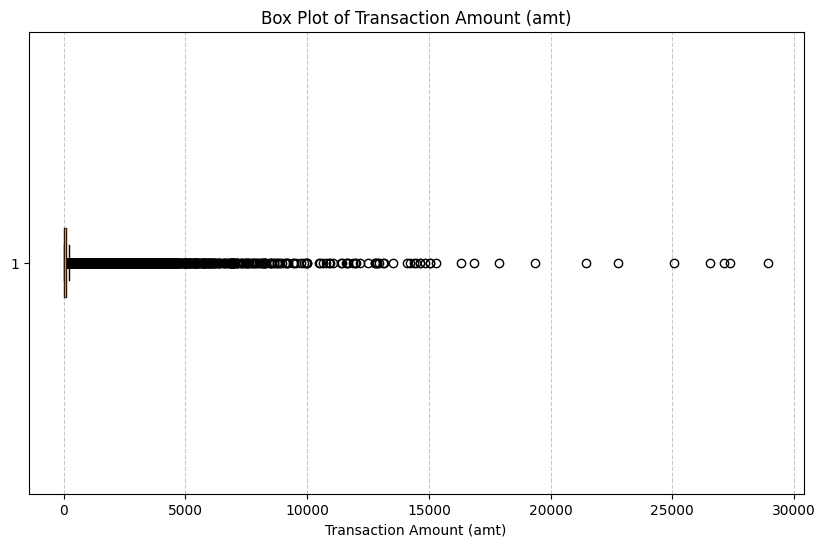

In [16]:
# amt 열의 박스플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(data['amt'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel('Transaction Amount (amt)')
plt.title('Box Plot of Transaction Amount (amt)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# amt 로그 변환
data['amt_log'] = np.log1p(data['amt'])

# 로버스트 스케일러 적용
scaler = RobustScaler()
data['amt_log_scaled'] = scaler.fit_transform(data[['amt_log']])

# 상한값 설정 (예: 상위 5%)
upper_limit = data['amt'].quantile(0.95)

# 이상치 플래그 추가
data['is_outlier'] = data['amt'] > upper_limit

data = data.drop(columns=['amt', 'amt_log'])

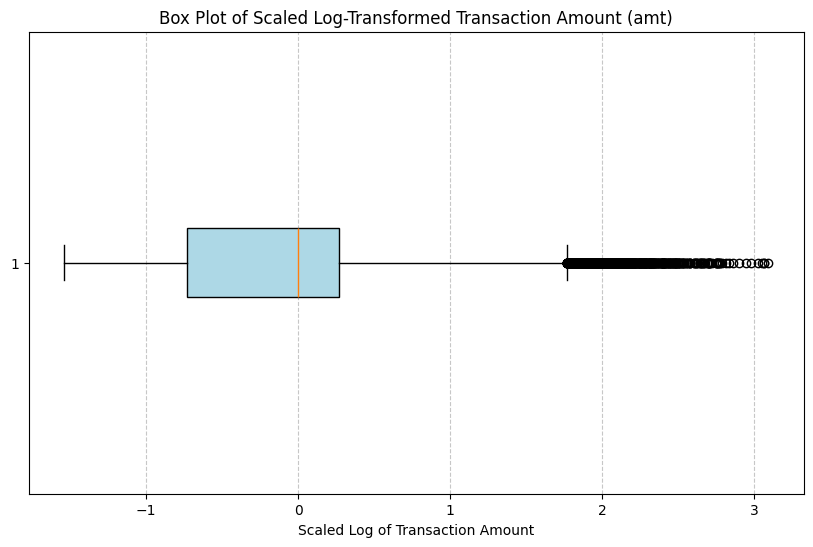

In [18]:
# amt_log_scaled 박스플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(data['amt_log_scaled'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel('Scaled Log of Transaction Amount')
plt.title('Box Plot of Scaled Log-Transformed Transaction Amount (amt)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [19]:
data.head()

,gender,city,state,zip,city_pop,job,is_fraud,speed,home_to_merch_distance,unusual_category,category_basic_living,category_entertainment_leisure,category_home_family,category_transportation_travel,amt_log_scaled,is_outlier
0,F,Fort Washakie,WY,82514,1645,Information systems manager,0,NaN,1.815415,0,False,True,False,False,-0.855137,False
1,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000037,1.133806,0,False,False,False,True,0.051921,False
2,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.006641,0.304629,0,False,False,False,True,0.260847,False
3,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000083,0.925290,0,False,False,True,False,-0.146496,False
4,F,Fort Washakie,WY,82514,1645,Information systems manager,0,0.000897,1.122202,0,False,False,True,False,-0.262128,False


### gender

In [20]:
# gender F, M을 0과 1로 변환 (원래 열을 변경)
gender_mapping = {'F': 0, 'M': 1}
data['gender'] = data['gender'].map(gender_mapping)

### 주소

In [21]:
# zip 코드를 앞 3자리로 변환
data['zip_prefix'] = data['zip'].astype(str).str[:3].astype(int)

# city, state, zip_prefix를 조합하여 새로운 열 생성
data['location_combined'] = data['city'] + '_' + data['state'] + '_' + data['zip_prefix'].astype(str)

# 사기 여부 평균값으로 인코딩 (Target Encoding) + 스무딩 적용
kf = KFold(n_splits=5, shuffle=True, random_state=42)
data['location_encoded'] = 0

global_mean = data['is_fraud'].mean()  # 전체 데이터의 사기 여부 평균
alpha = 10  # 스무딩의 정도를 결정하는 하이퍼파라미터

for train_idx, val_idx in kf.split(data):
    train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
    
    # 사기 여부 평균값과 해당 그룹의 크기 계산
    group_stats = train_data.groupby('location_combined')['is_fraud'].agg(['mean', 'count'])
    
    # 스무딩 적용한 평균값 계산
    group_stats['smoothed'] = (group_stats['count'] * group_stats['mean'] + alpha * global_mean) / (group_stats['count'] + alpha)
    
    # 검증 데이터에 매핑
    val_data_encoded = val_data['location_combined'].map(group_stats['smoothed'])
    data.loc[val_idx, 'location_encoded'] = val_data_encoded

# 기존 city, state, zip 열 제거
data = data.drop(columns=['city', 'state', 'zip', 'zip_prefix', 'location_combined'])

C:\Users\PhamPham\AppData\Local\Temp\ipykernel_15852\3716601469.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0044202 0.0044202 0.0044202 ... 0.0034206 0.0034206 0.0034206]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[val_idx, 'location_encoded'] = val_data_encoded


In [22]:
data.head()

,gender,city_pop,job,is_fraud,speed,home_to_merch_distance,unusual_category,category_basic_living,category_entertainment_leisure,category_home_family,category_transportation_travel,amt_log_scaled,is_outlier,location_encoded
0,0,1645,Information systems manager,0,NaN,1.815415,0,False,True,False,False,-0.855137,False,0.003412
1,0,1645,Information systems manager,0,0.000037,1.133806,0,False,False,False,True,0.051921,False,0.003412
2,0,1645,Information systems manager,0,0.006641,0.304629,0,False,False,False,True,0.260847,False,0.004127
3,0,1645,Information systems manager,0,0.000083,0.925290,0,False,False,True,False,-0.146496,False,0.004420
4,0,1645,Information systems manager,0,0.000897,1.122202,0,False,False,True,False,-0.262128,False,0.003941


### city_pop

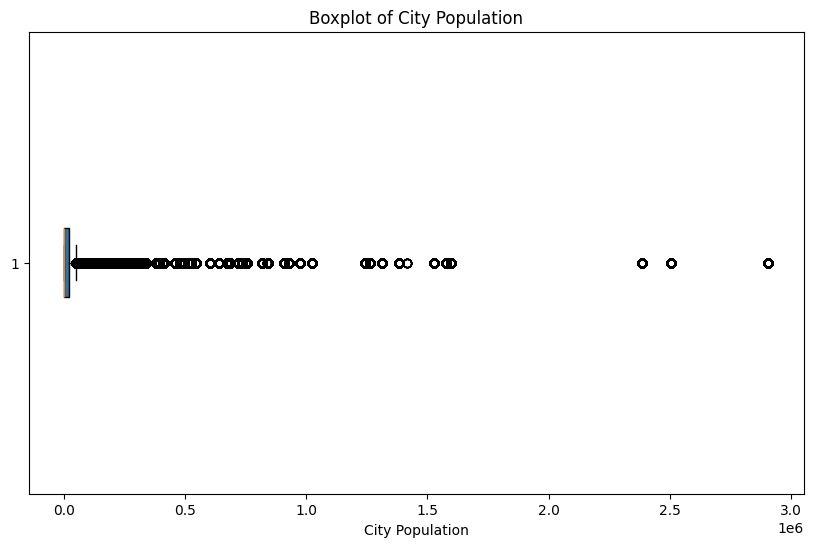

In [23]:
# 박스플롯을 그리기 위한 코드
plt.figure(figsize=(10, 6))
plt.boxplot(data['city_pop'], vert=False, patch_artist=True)
plt.xlabel('City Population')
plt.title('Boxplot of City Population')
plt.show()

In [24]:
# city_pop 로그 변환
data['city_pop_log'] = np.log1p(data['city_pop'])

# 로버스트 스케일러 적용
scaler = RobustScaler()
data['city_pop_scaled'] = scaler.fit_transform(data[['city_pop_log']])

# 상한값 설정 (예: 상위 5%)
upper_limit = data['city_pop'].quantile(0.95)

# 이상치 플래그 추가
data['city_pop_is_outlier'] = data['city_pop'] > upper_limit

# 기존 열 삭제
data = data.drop(columns=['city_pop', 'city_pop_log'])

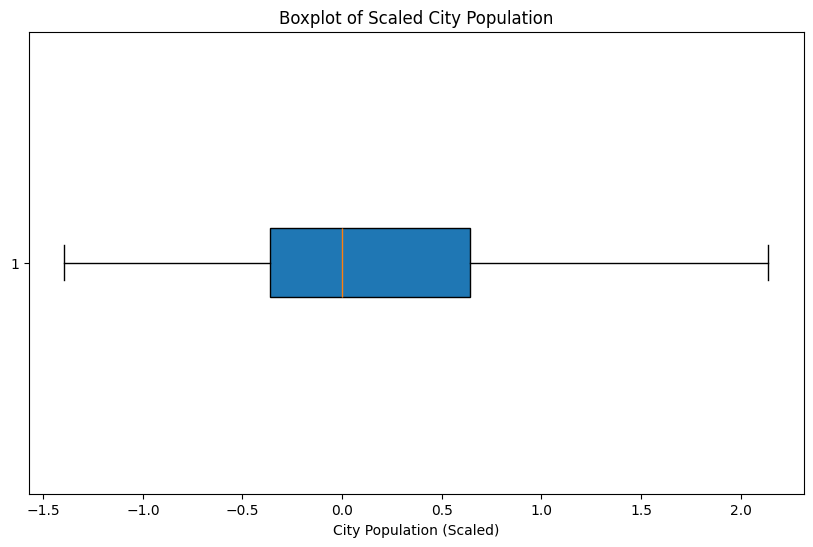

In [25]:
# 결과 확인 (박스플롯 시각화)
plt.figure(figsize=(10, 6))
plt.boxplot(data['city_pop_scaled'], vert=False, patch_artist=True)
plt.xlabel('City Population (Scaled)')
plt.title('Boxplot of Scaled City Population')
plt.show()

In [26]:
data.head()

,gender,job,is_fraud,speed,home_to_merch_distance,unusual_category,category_basic_living,category_entertainment_leisure,category_home_family,category_transportation_travel,amt_log_scaled,is_outlier,location_encoded,city_pop_scaled,city_pop_is_outlier
0,0,Information systems manager,0,NaN,1.815415,0,False,True,False,False,-0.855137,False,0.003412,-0.119406,False
1,0,Information systems manager,0,0.000037,1.133806,0,False,False,False,True,0.051921,False,0.003412,-0.119406,False
2,0,Information systems manager,0,0.006641,0.304629,0,False,False,False,True,0.260847,False,0.004127,-0.119406,False
3,0,Information systems manager,0,0.000083,0.925290,0,False,False,True,False,-0.146496,False,0.004420,-0.119406,False
4,0,Information systems manager,0,0.000897,1.122202,0,False,False,True,False,-0.262128,False,0.003941,-0.119406,False


### job

In [27]:
print(data["job"].value_counts().sort_index())

job
Academic librarian                                              1467
Accountant, chartered                                             11
Accountant, chartered certified                                  751
Accountant, chartered public finance                            3657
Accounting technician                                           6595
Acupuncturist                                                   2198
Administrator                                                   5115
Administrator, arts                                              736
Administrator, charities/voluntary organisations                3662
Administrator, education                                        3672
Administrator, local government                                 3677
Advertising account executive                                   2213
Advertising account planner                                     5852
Advertising copywriter                                          1466
Advice worker                 

In [28]:
# 직업 카테고리 정의
def categorize_job(job_title):
    if 'nurse' in job_title.lower() or 'doctor' in job_title.lower() or 'psychologist' in job_title.lower() or 'health' in job_title.lower() or 'pharmacist' in job_title.lower():
        return 'Healthcare'
    elif 'teacher' in job_title.lower() or 'lecturer' in job_title.lower() or 'professor' in job_title.lower() or 'education' in job_title.lower():
        return 'Education'
    elif 'accountant' in job_title.lower() or 'finance' in job_title.lower() or 'banker' in job_title.lower() or 'trader' in job_title.lower() or 'chief' in job_title.lower():
        return 'Finance/Business'
    elif 'engineer' in job_title.lower() or 'it' in job_title.lower() or 'developer' in job_title.lower() or 'scientist' in job_title.lower():
        return 'Technology/IT'
    elif 'administrator' in job_title.lower() or 'manager' in job_title.lower() or 'executive' in job_title.lower() or 'office' in job_title.lower():
        return 'Administration/Management'
    elif 'artist' in job_title.lower() or 'designer' in job_title.lower() or 'musician' in job_title.lower() or 'writer' in job_title.lower() or 'animator' in job_title.lower():
        return 'Arts/Creative'
    elif 'engineer' in job_title.lower() or 'architect' in job_title.lower() or 'construction' in job_title.lower():
        return 'Construction/Engineering'
    elif 'lawyer' in job_title.lower() or 'legal' in job_title.lower() or 'solicitor' in job_title.lower() or 'barrister' in job_title.lower():
        return 'Legal'
    elif 'research' in job_title.lower() or 'scientist' in job_title.lower() or 'chemist' in job_title.lower() or 'lab' in job_title.lower():
        return 'Science/Research'
    elif 'sales' in job_title.lower() or 'marketing' in job_title.lower() or 'merchandiser' in job_title.lower() or 'public relations' in job_title.lower():
        return 'Sales/Marketing'
    elif 'horticulturist' in job_title.lower() or 'agricultural' in job_title.lower() or 'environmental' in job_title.lower() or 'conservation' in job_title.lower():
        return 'Agriculture/Environment'
    elif 'social' in job_title.lower() or 'community' in job_title.lower() or 'police' in job_title.lower() or 'firefighter' in job_title.lower():
        return 'Public/Social Services'
    else:
        return 'Other'

# 새로운 job_category 열 생성
data['job_category'] = data['job'].apply(categorize_job)

# 기존 job 열 삭제
data = data.drop(columns=['job'])

In [29]:
# 사기 여부 평균값으로 인코딩 (Target Encoding) + 스무딩 적용
kf = KFold(n_splits=5, shuffle=True, random_state=42)
data['job_category_encoded'] = 0

global_mean = data['is_fraud'].mean()  # 전체 데이터의 사기 여부 평균
alpha = 10  # 스무딩의 정도를 결정하는 하이퍼파라미터

for train_idx, val_idx in kf.split(data):
    train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
    
    # 사기 여부 평균값과 해당 그룹의 크기 계산
    group_stats = train_data.groupby('job_category')['is_fraud'].agg(['mean', 'count'])
    
    # 스무딩 적용한 평균값 계산
    group_stats['smoothed'] = (group_stats['count'] * group_stats['mean'] + alpha * global_mean) / (group_stats['count'] + alpha)
    
    # 검증 데이터에 매핑
    val_data_encoded = val_data['job_category'].map(group_stats['smoothed'])
    data.loc[val_idx, 'job_category_encoded'] = val_data_encoded

# 기존 job_category 열 삭제
data = data.drop(columns=['job_category'])

C:\Users\PhamPham\AppData\Local\Temp\ipykernel_15852\2998855388.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00616033 0.00616033 0.00616033 ... 0.00502421 0.00502421 0.00502421]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[val_idx, 'job_category_encoded'] = val_data_encoded


In [30]:
# 전체 칼럼에 대해 True/False를 0과 1로 변환
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)
data.head()

C:\Users\PhamPham\AppData\Local\Temp\ipykernel_15852\1961473709.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)


,gender,is_fraud,speed,home_to_merch_distance,unusual_category,category_basic_living,category_entertainment_leisure,category_home_family,category_transportation_travel,amt_log_scaled,is_outlier,location_encoded,city_pop_scaled,city_pop_is_outlier,job_category_encoded
0,0,0,NaN,1.815415,0,0,1,0,0,-0.855137,0,0.003412,-0.119406,0,0.006254
1,0,0,0.000037,1.133806,0,0,0,0,1,0.051921,0,0.003412,-0.119406,0,0.006254
2,0,0,0.006641,0.304629,0,0,0,0,1,0.260847,0,0.004127,-0.119406,0,0.006192
3,0,0,0.000083,0.925290,0,0,0,1,0,-0.146496,0,0.004420,-0.119406,0,0.006160
4,0,0,0.000897,1.122202,0,0,0,1,0,-0.262128,0,0.003941,-0.119406,0,0.006010


# Modeling

In [52]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib

In [54]:
# Feature와 Target 설정
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

# 결측치 제거 후 인덱스 리셋
X = X.dropna().reset_index(drop=True)
y = y[X.index].reset_index(drop=True)

# 데이터 분할 (train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 설정
models = {
    "XGBoost": XGBClassifier(objective='binary:logistic', eval_metric='auc', n_jobs=-1),  
    "RandomForest": RandomForestClassifier(n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=500, n_jobs=-1, solver='lbfgs')  # solver를 lbfgs로 설정해 속도 개선
}

# 하이퍼파라미터 범위 축소
param_distributions = {
    "XGBoost": {
        'classifier__n_estimators': np.arange(100, 125, 25),  # 탐색 범위 축소
        'classifier__max_depth': [3],  # 고정
        'classifier__learning_rate': [0.03],  # 고정
        'classifier__subsample': [0.85],  # 고정
        'classifier__colsample_bytree': [0.85]  # 고정
    },
    "RandomForest": {
        'classifier__n_estimators': [75],  # 고정
        'classifier__max_depth': [5],  # 고정
        'classifier__min_samples_split': [2],  # 고정
        'classifier__min_samples_leaf': [1]  # 고정
    },
    "LogisticRegression": {
        'classifier__C': [1],  # 고정
        'classifier__penalty': ['l2']
    }
}

# 각 모델에 대해 파이프라인 설정 및 하이퍼파라미터 탐색
temp_best_params = {}
for model_name, model in models.items():
    print(f"\nRandom Search for model: {model_name}")
    
    # 파이프라인 설정 (SMOTE -> 모델)
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),  # 샘플링 전략 축소로 속도 개선
        ('classifier', model)
    ])
    
    # 좁힌 하이퍼파라미터 범위
    refined_param_distributions = param_distributions[model_name]
    
    # 직접 하이퍼파라미터 선택 (랜덤으로 3번 시도)
    best_score = 0
    best_params = None
    for i in range(3):  # 3번 반복하여 랜덤한 하이퍼파라미터로 학습
        params = {key: np.random.choice(value) for key, value in refined_param_distributions.items()}
        pipeline.set_params(**params)
        
        # 학습 및 평가
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)  # test set에서 평가
        
        if score > best_score:
            best_score = score
            best_params = params
    
    # 임시 최적의 하이퍼파라미터 저장
    temp_best_params[model_name] = best_params
    print(f"Temp Best Parameters for {model_name}: {best_params}")
    print(f"Best Score for {model_name}: {best_score}")


Random Search for model: XGBoost
Temp Best Parameters for XGBoost: {'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.03, 'classifier__subsample': 0.85, 'classifier__colsample_bytree': 0.85}
Best Score for XGBoost: 0.9534476099937613

Random Search for model: RandomForest
Temp Best Parameters for RandomForest: {'classifier__n_estimators': 75, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1}
Best Score for RandomForest: 0.9947876015134861

Random Search for model: LogisticRegression
Temp Best Parameters for LogisticRegression: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best Score for LogisticRegression: 0.9877576153682033

Temporary Best Parameters for each model:
XGBoost: {'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.03, 'classifier__subsample': 0.85, 'classifier__colsample_bytree': 0.85}
RandomForest: {'classifier__n_estimators': 75, 'class

Random Search for model: XGBoost
Temp Best Parameters for XGBoost: {'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.03, 'classifier__subsample': 0.85, 'classifier__colsample_bytree': 0.85}
Best Score for XGBoost: 0.9534476099937613

Random Search for model: RandomForest
Temp Best Parameters for RandomForest: {'classifier__n_estimators': 75, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1}
Best Score for RandomForest: 0.9947876015134861

Random Search for model: LogisticRegression
Temp Best Parameters for LogisticRegression: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best Score for LogisticRegression: 0.9877576153682033

Temporary Best Parameters for each model:
XGBoost: {'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.03, 'classifier__subsample': 0.85, 'classifier__colsample_bytree': 0.85}
RandomForest: {'classifier__n_estimators': 75, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1}
LogisticRegression: {'classifier__C': 1, 'classifier__penalty': 'l2'}

In [ ]:
# 임시 최적 하이퍼파라미터 기반으로 2차 탐색 범위 설정
param_distributions_refined = {
    "XGBoost": {
        'classifier__n_estimators': np.arange(temp_best_params["XGBoost"]['classifier__n_estimators'] - 10, temp_best_params["XGBoost"]['classifier__n_estimators'] + 10, 5),  # 근처에서 범위 설정
        'classifier__max_depth': np.arange(temp_best_params["XGBoost"]['classifier__max_depth'] - 1, temp_best_params["XGBoost"]['classifier__max_depth'] + 1, 1),
        'classifier__learning_rate': np.linspace(temp_best_params["XGBoost"]['classifier__learning_rate'] * 0.9, temp_best_params["XGBoost"]['classifier__learning_rate'] * 1.1, 3),
        'classifier__subsample': np.linspace(temp_best_params["XGBoost"]['classifier__subsample'] * 0.9, temp_best_params["XGBoost"]['classifier__subsample'] * 1.1, 3),
        'classifier__colsample_bytree': np.linspace(temp_best_params["XGBoost"]['classifier__colsample_bytree'] * 0.9, temp_best_params["XGBoost"]['classifier__colsample_bytree'] * 1.1, 3)
    },
    "RandomForest": {
        'classifier__n_estimators': np.arange(temp_best_params["RandomForest"]['classifier__n_estimators'] - 10, temp_best_params["RandomForest"]['classifier__n_estimators'] + 10, 5),
        'classifier__max_depth': np.arange(temp_best_params["RandomForest"]['classifier__max_depth'] - 1, temp_best_params["RandomForest"]['classifier__max_depth'] + 1, 1),
        'classifier__min_samples_split': [temp_best_params["RandomForest"]['classifier__min_samples_split']],
        'classifier__min_samples_leaf': [temp_best_params["RandomForest"]['classifier__min_samples_leaf']]
    },
    "LogisticRegression": {
        'classifier__C': np.linspace(temp_best_params["LogisticRegression"]['classifier__C'] * 0.9, temp_best_params["LogisticRegression"]['classifier__C'] * 1.1, 3),
        'classifier__penalty': [temp_best_params["LogisticRegression"]['classifier__penalty']]
    }
}

# 2차 탐색
final_best_params = {}
for model_name, model in models.items():
    print(f"\nRefined Search for model: {model_name}")
    
    # 파이프라인 설정 (SMOTE -> 모델)
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # 좁힌 하이퍼파라미터 범위
    refined_param_distributions = param_distributions_refined[model_name]
    
    # 직접 하이퍼파라미터 선택 (랜덤으로 3번 시도)
    best_score = 0
    best_params = None
    for i in range(3):  # 3번 반복하여 랜덤한 하이퍼파라미터로 학습
        params = {key: np.random.choice(value) for key, value in refined_param_distributions.items()}
        pipeline.set_params(**params)
        
        # 학습 및 평가
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)  # test set에서 평가
        
        if score > best_score:
            best_score = score
            best_params = params
    
    # 최종 최적의 하이퍼파라미터 저장
    final_best_params[model_name] = best_params
    print(f"Final Best Parameters for {model_name}: {best_params}")
    print(f"Best Score for {model_name}: {best_score}")

# 최종 하이퍼파라미터 출력
print("\nFinal Best Parameters for each model:")
for model_name, best_params in final_best_params.items():
    print(f"{model_name}: {best_params}")